<a href="https://colab.research.google.com/github/BishalBiswal/Improved-brain-tumour-classification-using-ViT/blob/main/ft_vitb16_3k.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ViT_B_16_Weights.IMAGENET1K_V1`. You can also use `weights=ViT_B_16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth
100%|██████████| 330M/330M [00:05<00:00, 60.3MB/s]


Epoch [1/100], Loss: 0.6244
Validation Loss: 1.0818
Epoch [2/100], Loss: 0.2217
Validation Loss: 1.0638
Epoch [3/100], Loss: 0.1493
Validation Loss: 1.0705
Epoch [4/100], Loss: 0.0979
Validation Loss: 0.9052
Epoch [5/100], Loss: 0.0702
Validation Loss: 0.9641
Epoch [6/100], Loss: 0.0641
Validation Loss: 1.1257
Epoch [7/100], Loss: 0.0442
Validation Loss: 1.1529
Epoch [8/100], Loss: 0.0429
Validation Loss: 0.8094
Epoch [9/100], Loss: 0.0412
Validation Loss: 0.9898
Epoch [10/100], Loss: 0.0286
Validation Loss: 1.2133
Epoch [11/100], Loss: 0.0197
Validation Loss: 0.8681
Epoch [12/100], Loss: 0.0240
Validation Loss: 1.1637
Epoch [13/100], Loss: 0.0163
Validation Loss: 1.1852
Early stopping triggered. No improvement in validation loss.
Training complete.


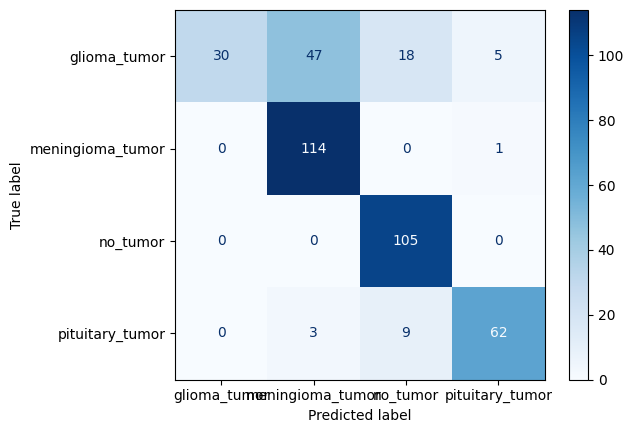

In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from torchvision.models import vit_b_16

# Define data augmentation
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomRotation(degrees=30),
    transforms.RandomHorizontalFlip(),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),  # Add color jittering
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0), ratio=(0.8, 1.2)),  # Random resized crop
    transforms.RandomPerspective(distortion_scale=0.2, p=0.5),  # Random perspective transformation
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load dataset
data_dir = '/content/drive/MyDrive/archive'
train_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Training'), transform=transform)
val_dataset = datasets.ImageFolder(os.path.join(data_dir, 'Testing'), transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Load pre-trained ViT model and fine-tune it for your number of classes
model = vit_b_16(pretrained=True)
# Access the last layer in the heads object
model.heads[-1] = nn.Linear(model.heads[-1].in_features, len(train_dataset.classes))  # Adjust the final layer
model = model.to('cuda' if torch.cuda.is_available() else 'cpu')

# Define dropout
model.dropout = nn.Dropout(0.2)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-5)

# Training loop
num_epochs = 100
best_val_loss = float('inf')
patience = 5  # Number of epochs to wait if validation loss doesn't improve
counter = 0  # Counter to track the number of epochs with no improvement

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Print training loss
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}')

    # Validation
    model.eval()
    val_loss = 0.0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to('cuda'), labels.to('cuda')
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

    val_loss /= len(val_loader)
    print(f'Validation Loss: {val_loss:.4f}')

    # Check for early stopping
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        counter = 0
    else:
        counter += 1

        if counter >= patience:
            print("Early stopping triggered. No improvement in validation loss.")
            break

print("Training complete.")

# Compute and plot confusion matrix
model.eval()
y_true = []
y_pred = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to('cuda'), labels.to('cuda')
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(preds.cpu().numpy())

# Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=train_dataset.classes)
disp.plot(cmap=plt.cm.Blues)
plt.show()